# Análisis del perfil crediticio de clientes bancarios



#### Autor: Samuel Arteaga López

En esta práctica vamos a llevar a cabo la tarea de crear dos modelos de inteligencia artificial para una entidad bancaria, cuyo objetivo es el siguiente:
- Prever si se concede el préstamo o no para posibles nuevos solicitantes, cuya variable objetivor será ``loan_status``
- Poder obtener la puntuación del riesgo. Cuya variable target es `risk_score`

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import optuna
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.datasets import make_classification

## 1. Carga del CSV

Aquí cargaremos una vista general del dataframe

In [3]:
df = pd.read_csv("csvs/loan_data.csv")
objetivo1 = 'loan_status'
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Echando un ojo de primeras podemos apreciar que los numeros son floats y el resto son datos categoricos excepto `previous_loans` y `loan_status` que funcionan como ``boolean``

Veamos una breve descripción de `loan_status`

In [4]:
print(df[objetivo1].describe())

count    45000.000000
mean         0.222222
std          0.415744
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64


## 2. Estudio de valores faltantes

Estructura de los datos, Datos faltantes, Valores únicos

Valores nulos

In [5]:
print(df.isnull().sum())

age                  0
gender               0
education            0
income               0
yrs_exp              0
ownership            0
amount               0
purpose             38
int_rate             0
percent_income       0
cred_hist_length     0
risk_score           0
previous_loans       0
loan_status          0
dtype: int64


Encontramos 38 valores nulos en purpose

Columnas del dataset

In [6]:
print(df.columns)

Index(['age', 'gender', 'education', 'income', 'yrs_exp', 'ownership',
       'amount', 'purpose', 'int_rate', 'percent_income', 'cred_hist_length',
       'risk_score', 'previous_loans', 'loan_status'],
      dtype='object')


Forma (filas, columnas)

In [7]:
print(df.shape)

(45000, 14)


Información general del dataframe

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               45000 non-null  float64
 1   gender            45000 non-null  object 
 2   education         45000 non-null  object 
 3   income            45000 non-null  float64
 4   yrs_exp           45000 non-null  int64  
 5   ownership         45000 non-null  object 
 6   amount            45000 non-null  float64
 7   purpose           44962 non-null  object 
 8   int_rate          45000 non-null  float64
 9   percent_income    45000 non-null  float64
 10  cred_hist_length  45000 non-null  float64
 11  risk_score        45000 non-null  int64  
 12  previous_loans    45000 non-null  object 
 13  loan_status       45000 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 4.8+ MB
None


Descripción de todas las columnas

In [9]:
print(df.describe(include='all'))

                 age gender education        income       yrs_exp ownership  \
count   45000.000000  45000     45000  4.500000e+04  45000.000000     45000   
unique           NaN      3         5           NaN           NaN         5   
top              NaN   male  Bachelor           NaN           NaN      RENT   
freq             NaN  24841     13399           NaN           NaN     23443   
mean       27.764178    NaN       NaN  8.031905e+04      5.410333       NaN   
std         6.045108    NaN       NaN  8.042250e+04      6.063532       NaN   
min        20.000000    NaN       NaN  8.000000e+03      0.000000       NaN   
25%        24.000000    NaN       NaN  4.720400e+04      1.000000       NaN   
50%        26.000000    NaN       NaN  6.704800e+04      4.000000       NaN   
75%        30.000000    NaN       NaN  9.578925e+04      8.000000       NaN   
max       144.000000    NaN       NaN  7.200766e+06    125.000000       NaN   

              amount    purpose      int_rate  perc

Posibles duplicados del dataframe

In [10]:
print(df.duplicated())

0        False
1        False
2        False
3        False
4        False
         ...  
44995    False
44996    False
44997    False
44998    False
44999    False
Length: 45000, dtype: bool


Como podemos apreciar hay 38 valores nulos en la columna ``purpose``, hay 45000 filas y 14 columnas y no hay duplicados, además se ha adjuntado una breve descripción de cada columna. <br><br>
Dado que `purpose` tiene 38 valores faltantes y es una variable `categorical` hay que transformarla a datos numericos, a continuación borraremos los valores faltantes ya que representan un porcentaje muy bajo en el dataset

In [11]:
df.dropna(inplace=True)
print(df.shape)

(44962, 14)


Como podemos apreciar se han  borrado los valores faltantes

### Visualizacion de datos

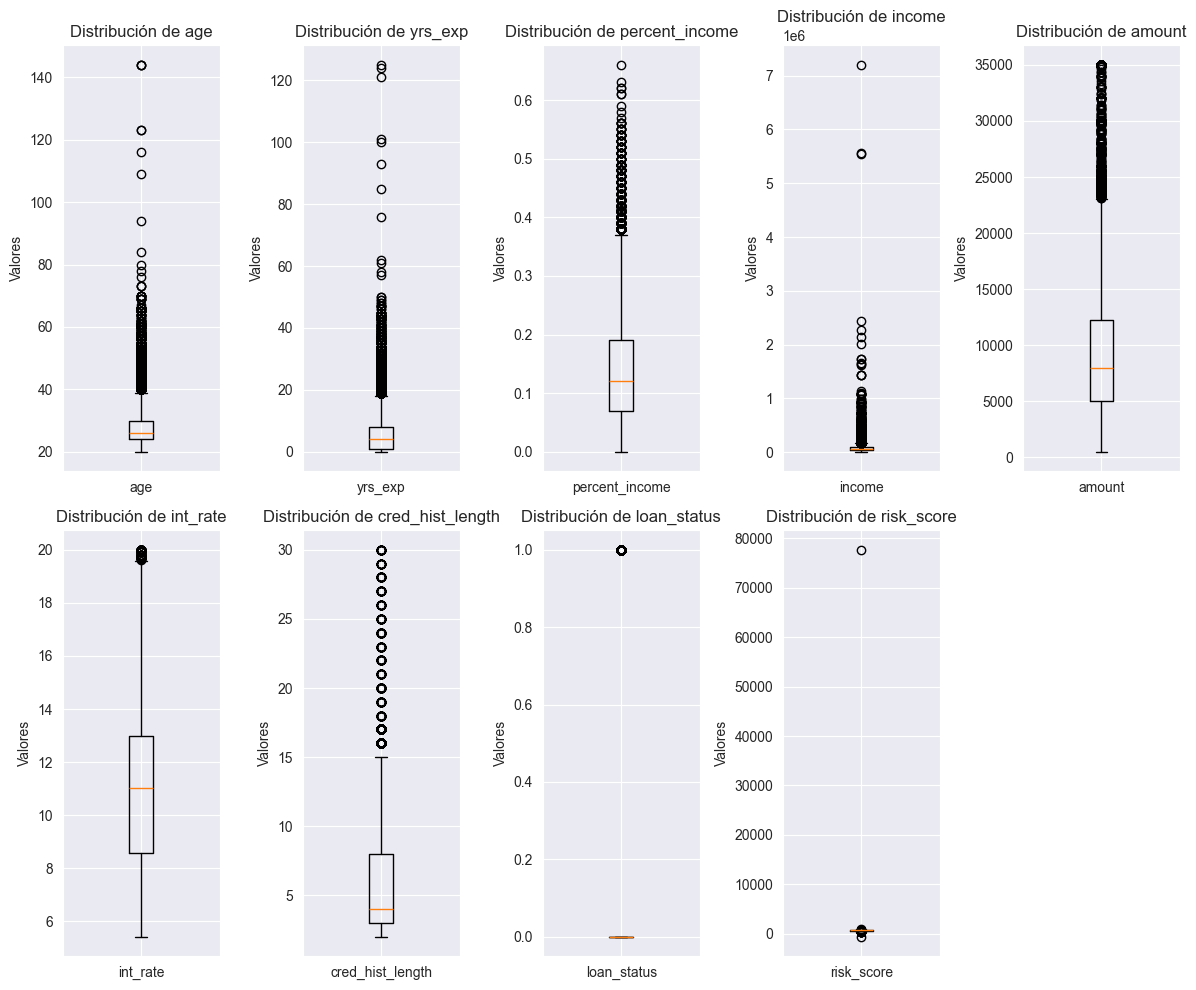

In [12]:
categorias = ['age', 'yrs_exp', 'percent_income', 'income', 'amount', 'int_rate', 'cred_hist_length', 'loan_status', 'risk_score']
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].boxplot(df[var], tick_labels=[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()


Como podemos apreciar en los gráficos `boxplot` encontramos algunos `outliers`, valores atípicos para los que presenta el fichero, se ha escogido todas las variables númericas excepto las targets `loan_status` y `risk_score` pues no presentan outliers

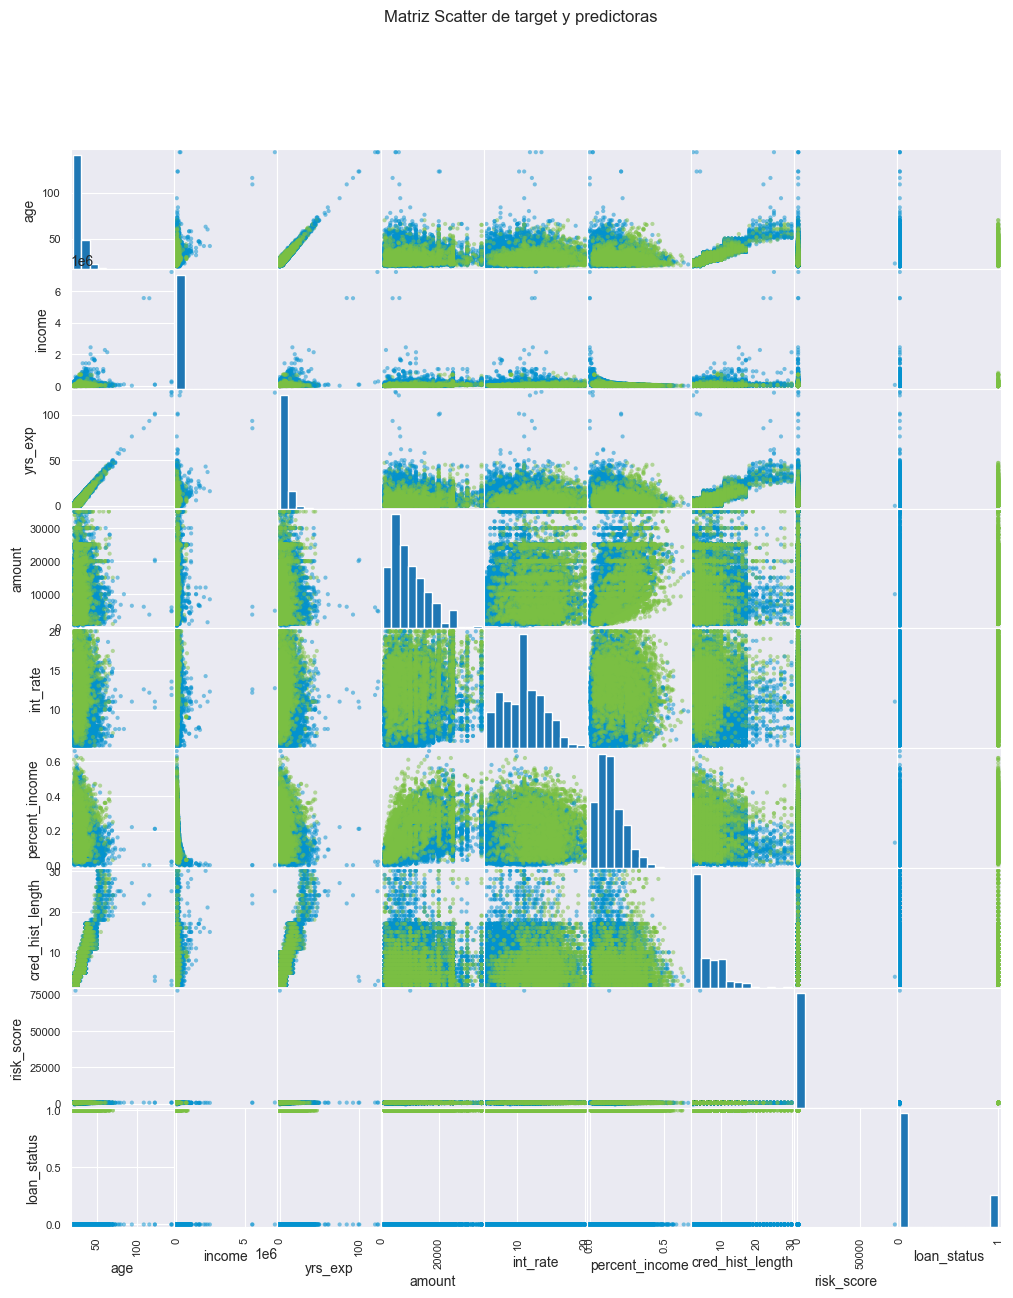

In [13]:
# scatter_matrix(df, figsize=(12, 12))
# plt.suptitle("Matriz de correlación de variables del dataframe", fontsize=12)
# plt.show()
mapa_colores = {0: '#0392cf', 1: '#7bc043'}  # 0 (clase negativa): blue, 1(positiva): green
colores = df['loan_status'].map(lambda x: mapa_colores.get(x))

pd.plotting.scatter_matrix(df, alpha=0.5, color=colores, figsize=(12,14), diagonal='hist', hist_kwds={'bins':12})

plt.suptitle('Matriz Scatter de target y predictoras')
plt.show()

In [14]:
print(df['gender'].value_counts())
df['gender'] = df['gender'].replace("femal", "female")
print(df['gender'].value_counts())

gender
male      24825
female    20136
femal         1
Name: count, dtype: int64
gender
male      24825
female    20137
Name: count, dtype: int64


Aquí hemos realizado un cambio en un valor atípico en la columna genero, donde ponía `femal` se ha cambiado a `female`

In [15]:
# Filtrar y mostrar el registro donde ownership es "OWN"
print(df['ownership'].value_counts())

ownership
RENT        23412
MORTGAGE    18482
OWN          2950
OTHER         117
OWN             1
Name: count, dtype: int64


⚠️ `OWN` está repetido dos veces por lo que deberá de ser tratado ⚠️

In [16]:
# Creamos una columna indicando si hay espacios en blanco
df['espaciosEnBlanco'] = df['ownership'].str.contains(r'\s')

print(df['espaciosEnBlanco'].value_counts())

espaciosEnBlanco
False    44961
True         1
Name: count, dtype: int64


Ya conocemos el motivo de la repetición, en uno de los valores que llevan `OWN` tiene un espacio en blanco, algo como esto ` OWN` procederemos a eliminarlo

In [17]:
df['ownership'] = df['ownership'].str.strip()
df['ownership'].value_counts()

ownership
RENT        23412
MORTGAGE    18482
OWN          2951
OTHER         117
Name: count, dtype: int64

Borramos la columna de los espacios ya que no la necesitamos más

In [18]:
df = df.drop('espaciosEnBlanco', axis=1)
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


Podemos comprobar que se ha eliminado correctamente el valor erroneo de la columna

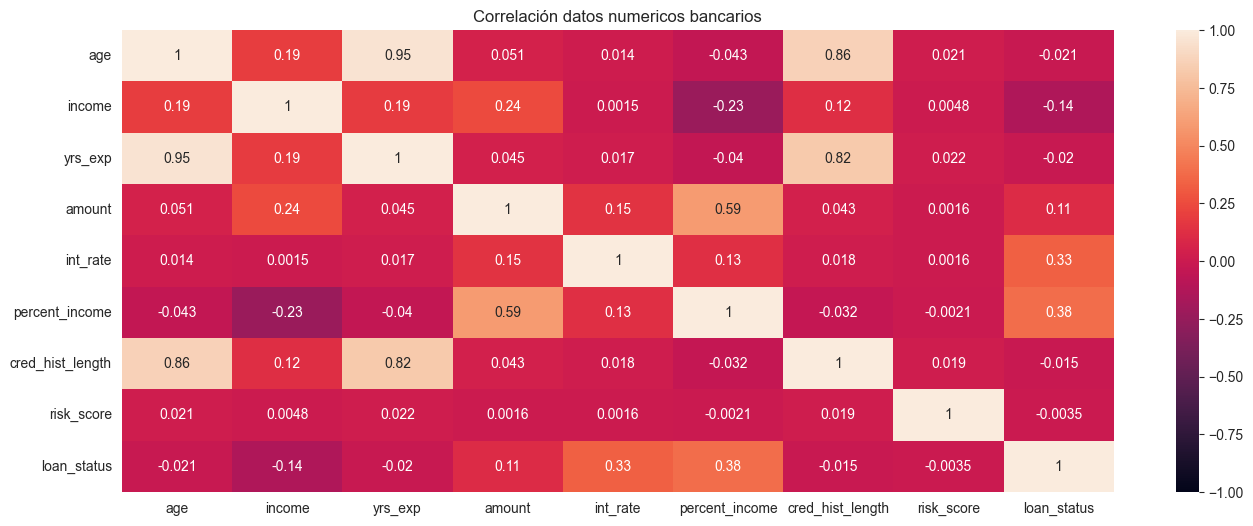

In [19]:
df_numericos = df.select_dtypes(include=np.number)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_numericos.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación datos numericos bancarios')
plt.show()

Se ha realizado un mapa de calor para comprobar la relacion entre las variables numericas, estos datos serán tratados más adelante. Sin haber realizado una ingeniería de características podemos resaltar algunas relaciones de las características del dataframe como lo puede ser `age` con `yrs_exp` o la primera con `cred_hist_length` entre otras

## 3. Ingenieria de características

Vamos a proceder a cambiar las variables categoricas `gender`, `education`, `ownership`, `purpose`, y `previous_loans`

In [20]:
# df.head() para tener una vista necesaria de que características hay que manipular
df.head()

,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [21]:
# Comprobamos que ya no tenemos valores nulos en el dataframe
df.isnull().sum()

age                 0
gender              0
education           0
income              0
yrs_exp             0
ownership           0
amount              0
purpose             0
int_rate            0
percent_income      0
cred_hist_length    0
risk_score          0
previous_loans      0
loan_status         0
dtype: int64

Procederemos a cambiar a tipo numerico las columnas categoricas:
- `Gender`: `female = 0` `male = 1`
- `Previous_loans`: `Yes = 0` `No = 1`

Filtramos los valores que estén por debajo de 100 años

In [22]:
# filtramos la columna age para quedarnos con edades por debajo de 100
df['age'] = df['age'].where(df['age'] < 100 )
df['age'].value_counts()
print(df['age'].isnull().sum())
df.dropna(inplace=True)
print(df.shape)
print(df['age'].isnull().sum())

7
(44955, 14)
0


Al igual que hemos hecho con `age`, filtraremos los valores normales frente a los atipicos en `yrs_exp`

In [23]:
df['yrs_exp'] = df['yrs_exp'].where(df['yrs_exp'] < 100 )
df['yrs_exp'].value_counts()
print(df['yrs_exp'].isnull().sum())
df.dropna(inplace=True)
print(df.shape)
print(df['yrs_exp'].isnull().sum())
df.head()

0
(44955, 14)
0


,age,gender,education,income,yrs_exp,ownership,amount,purpose,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [24]:
df['gender'] = df['gender'].replace(['female', 'male'], [0, 1])
df['previous_loans'] = df['previous_loans'].replace(['Yes', 'No'], [0, 1])

# Instanciar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Crea un array en vez de una matriz

# Aplicar el encoder a las columnas categóricas
categoricas = ['education', 'ownership', 'purpose']
valores = encoder.fit_transform(df[categoricas])

# Crear un DataFrame con los valores codificados
columnas_codificadas = encoder.get_feature_names_out(categoricas)
df_codificado = pd.DataFrame(valores, columns=columnas_codificadas, index=df.index)

# Concatenar el DataFrame original con las columnas codificadas
df = pd.concat([df.drop(columns=categoricas, axis=1), df_codificado], axis=1)

# Mostrar el DataFrame final
print(df.isnull().sum())

C:\Users\ESP\AppData\Local\Temp\ipykernel_12760\3030420232.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace(['female', 'male'], [0, 1])
C:\Users\ESP\AppData\Local\Temp\ipykernel_12760\3030420232.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['previous_loans'] = df['previous_loans'].replace(['Yes', 'No'], [0, 1])


age                          0
gender                       0
income                       0
yrs_exp                      0
amount                       0
int_rate                     0
percent_income               0
cred_hist_length             0
risk_score                   0
previous_loans               0
loan_status                  0
education_Associate          0
education_Bachelor           0
education_Doctorate          0
education_High School        0
education_Master             0
ownership_MORTGAGE           0
ownership_OTHER              0
ownership_OWN                0
ownership_RENT               0
purpose_DEBTCONSOLIDATION    0
purpose_EDUCATION            0
purpose_HOMEIMPROVEMENT      0
purpose_MEDICAL              0
purpose_PERSONAL             0
purpose_VENTURE              0
dtype: int64


Hemos realizado ingenería de caracteríticas sobre las variables categóricas para proceder a la visualización de las relaciones entre las variables del dataframe, dado que tenemos bastantes, el uso de `OneHotEncoder` se debe a la optimización en variables independientes (features).

In [25]:
# Para comprobar como queda el dataset una vez realizada la ingeniería con todas las variables categóricas del modelo
df.head()

,age,gender,income,yrs_exp,amount,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,...,ownership_MORTGAGE,ownership_OTHER,ownership_OWN,ownership_RENT,purpose_DEBTCONSOLIDATION,purpose_EDUCATION,purpose_HOMEIMPROVEMENT,purpose_MEDICAL,purpose_PERSONAL,purpose_VENTURE
0,22.0,0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,21.0,0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,25.0,0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23.0,0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24.0,1,66135.0,1,35000.0,14.27,0.53,4.0,586,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


### Mapa de calor

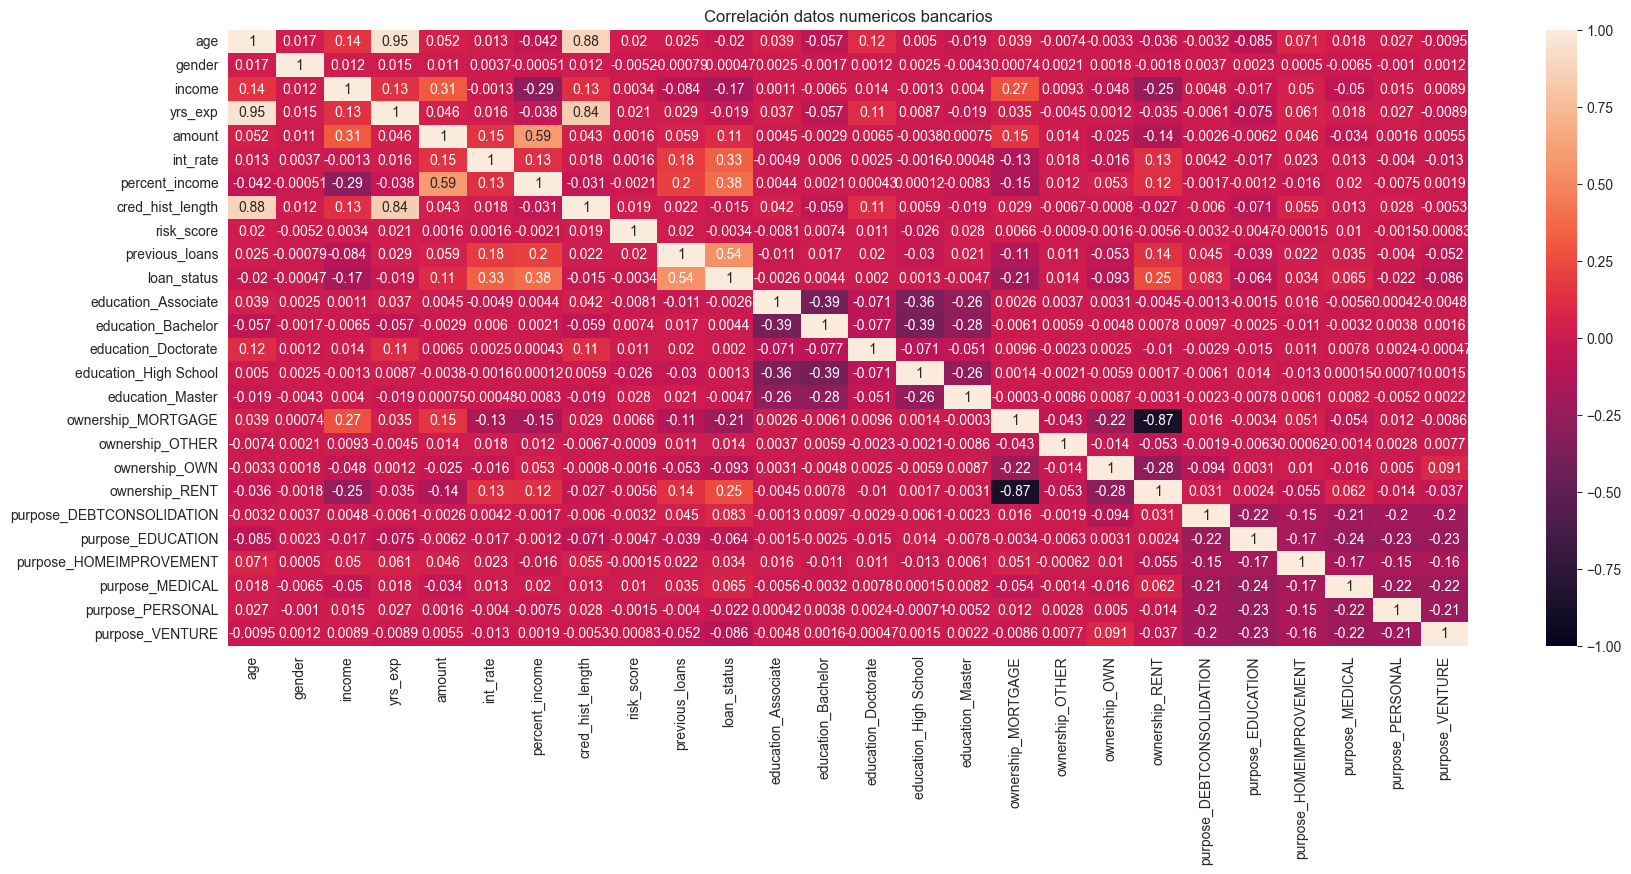

In [26]:
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlación datos numericos bancarios')
plt.show()

Teniendo en cuenta el resultado que hemos obtenido en el mapa de calor con todas las variables categóricas transformadas a numericas se ha tomado la decisión de quedarnos con el siguiente listado de características para entrenar sobre la variable target `loan_status`:
``income``, ``amount``, ``int_rate``, ``percent_income``, ``previous_loans``, ``ownership_MORTGAGE``, ``ownership_RENT``

In [27]:
print(df.columns)

Index(['age', 'gender', 'income', 'yrs_exp', 'amount', 'int_rate',
       'percent_income', 'cred_hist_length', 'risk_score', 'previous_loans',
       'loan_status', 'education_Associate', 'education_Bachelor',
       'education_Doctorate', 'education_High School', 'education_Master',
       'ownership_MORTGAGE', 'ownership_OTHER', 'ownership_OWN',
       'ownership_RENT', 'purpose_DEBTCONSOLIDATION', 'purpose_EDUCATION',
       'purpose_HOMEIMPROVEMENT', 'purpose_MEDICAL', 'purpose_PERSONAL',
       'purpose_VENTURE'],
      dtype='object')


Una vez hecha la ingenería de características procederemos a testear los valores de prueba con diferentes modelos crearemos un dataframe con las variables con más correlación con loan_status que hemos mencionado antes, excluiremos loan_status para no generar ruido en los datos de validación y prueba y a partir de la creación de los modelos y su entrenamiento seguiremos la misma plantilla de proceso para todos

In [28]:
datos1 = df[["income", "amount", "int_rate", "percent_income", "previous_loans", "ownership_MORTGAGE", "ownership_RENT"]]

# Separar características (X) y variable objetivo (y)
X = df.drop(columns=["loan_status"])  # Excluir la variable objetivo
y = df["loan_status"]                 # Variable objetivo

# Dividimos los datos en un 80% para entrenamiento y un 20% para evaluación (validación + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# De los datos temporales (X_temp, y_temp), dividimos en validación (10%) y test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Entrenar el modelo
dtr = DecisionTreeRegressor(random_state=42, max_depth=7, min_samples_split=10)
dtr.fit(X_train, y_train)  # Usar X_train y y_train

# Predecir sobre el conjunto de validación
predicciones = dtr.predict(X_val)  # Usar X_val para predicciones

# Calcular el error
error_val = mean_absolute_error(y_val, predicciones)  # Comparar con y_val
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.1174562753862622


Hemos obtenido una métrica de error del 0.119 con el modelo `DecisionTreeRegressor` procederemos a probar otros para contrastar


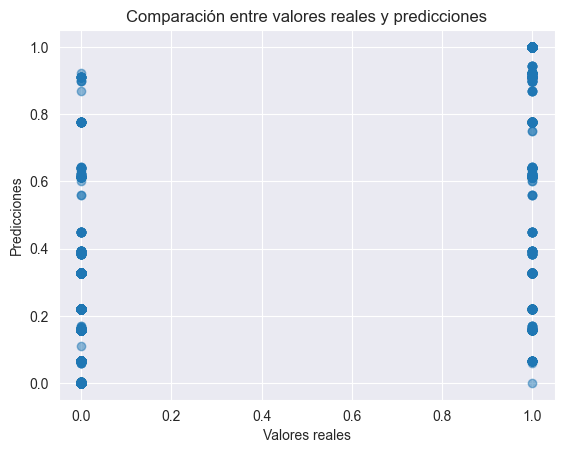

In [29]:
plt.scatter(y_val, predicciones, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()

Como podemos obersvar en el gráfico de comparación hay bastantes similitudes entre la predicción y lo real, lo cual es un buen resultado

In [30]:
# Crear y entrenar el modelo RandomForestRegressor
rfr = RandomForestRegressor(random_state=42, max_depth=7, min_samples_split=10)
rfr.fit(X_train, y_train)  # Usar X_train y y_train para entrenar el modelo

# Predecir sobre el conjunto de validación
predicciones = rfr.predict(X_val)  # Usar X_val para predecir las etiquetas

# Calcular el error de validación
error_val = mean_absolute_error(y_val, predicciones)  # Comparar con y_val
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.11645280875955313


Vemos que ``RandomForestRegressor`` lo mejora por muy poco

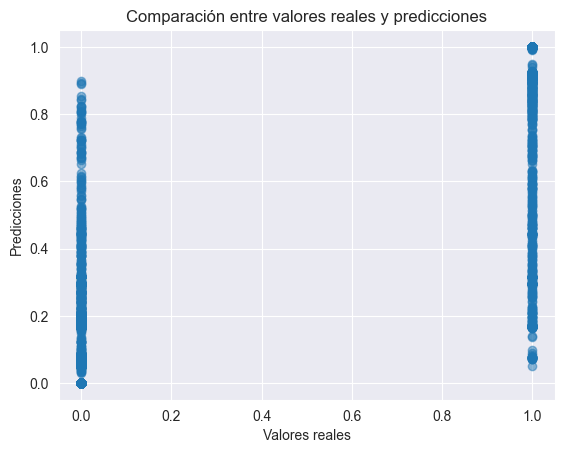

In [31]:
plt.scatter(y_val, predicciones, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()

In [32]:
rfr = RandomForestRegressor(random_state=42, max_depth=10,  criterion='squared_error', min_samples_split=20)
rfr.fit(X_train, y_train)

predicciones = rfr.predict(X_val)

error_val = mean_absolute_error(y_val, predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.10774309404590014


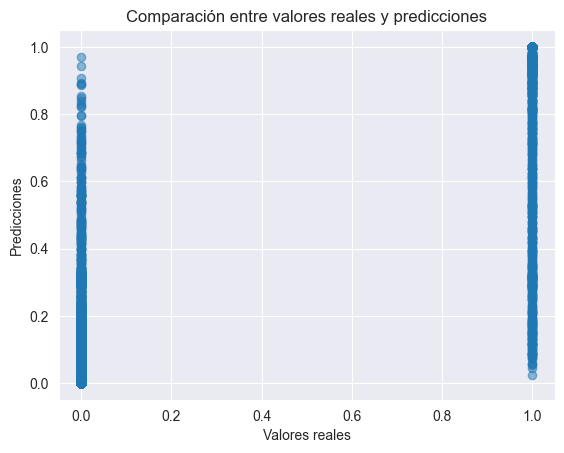

In [33]:
plt.scatter(y_val, predicciones, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()

¿Por qué hemos optado por el hiperparámetro `squared_error` y no otro? Suele ser el más habitual para el modelo de clasificación en el que nos encontramos.<br><br>
Habiendo añadido el `criterion=squared_error` hemos reducido un poco la métrica de error en comparación con el predecesor `RandomForestRegressor`

In [34]:
# Entrenar el modelo
gbr = GradientBoostingRegressor(random_state=42, n_estimators=100, max_depth=7)
gbr.fit(X_train, y_train)

# Predecir y calcular el error
predicciones = gbr.predict(X_val)
error_val = mean_absolute_error(y_val, predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.10812168313214833


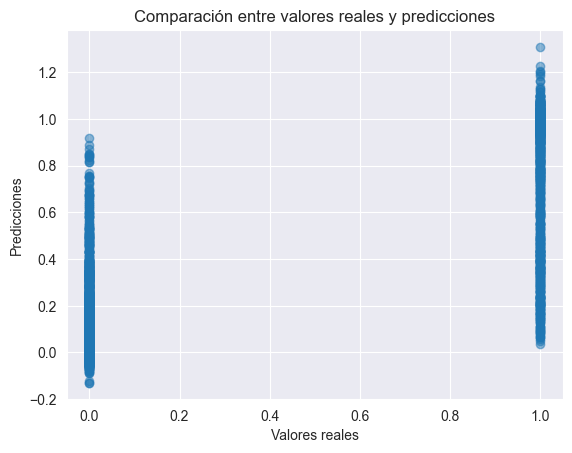

In [35]:
plt.scatter(y_val, predicciones, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()

In [36]:
# Entrenar el modelo
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predecir y calcular el error
predicciones = lr.predict(X_val)
error_val = mean_absolute_error(y_val, predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.23986880297629018


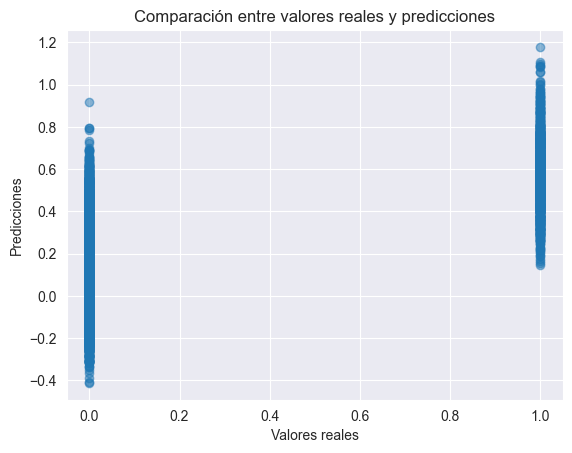

In [37]:
plt.scatter(y_val, predicciones, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()


In [38]:
knr = KNeighborsRegressor(n_neighbors=3)
knr.fit(X_train, y_train)

predicciones = knr.predict(X_val)
error_val = mean_absolute_error(y_val, predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.20118650352243234


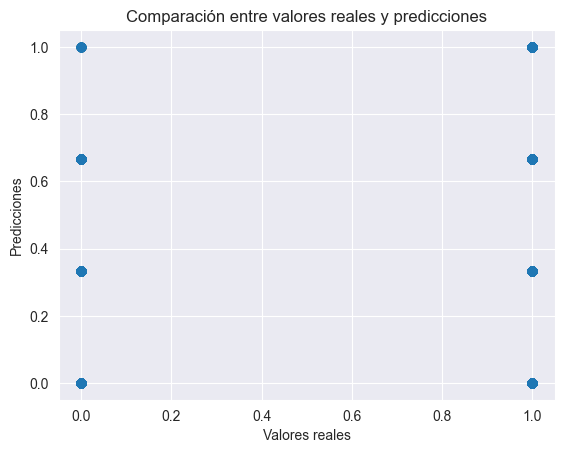

In [39]:
plt.scatter(y_val, predicciones, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()

Estos tres últimos modelos no los hemos descrito ya que nos encontramos ante un problema de clasificación y no de regresión a lo que el primer modelo respecta, por lo tanto para ya decidir con cual nos quedamos haremos una prueba con `RandomForestClassifier`, y, dependiendo del resultado que obtengamos usaremos este o su homólogo regresor, ¿Pero por qué vamos a usar un regressor si he dicho que estos tres ultimos modelos los hemos descartado precisamente por ser regressors? Porque la métrica que ha dado de error es bastante baja

In [40]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
predicciones = clf.predict(X_val)
error_val = mean_absolute_error(y_val, predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.07252502780867631


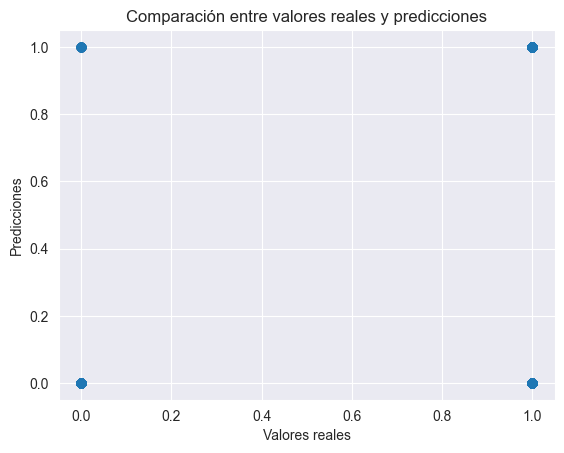

In [41]:
plt.scatter(y_val, predicciones, alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Comparación entre valores reales y predicciones")
plt.show()

Como podemos observar por la métrica y el gráfico de comparación hemos obtenido un 0.07 de error, por lo tanto trabajaremos con este modelo en adelante y predeciremos si se otorga el prestamo o no

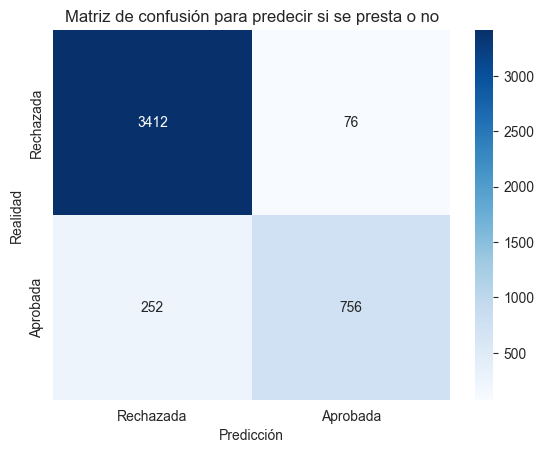

In [42]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Rechazada", "Aprobada"], yticklabels=["Rechazada", "Aprobada"])
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de confusión para predecir si se presta o no")
plt.show()

Dada la matriz de confusión podemos comprobar que la proporción de acierto supera bastante a la proporción erronea, con rechazados que sí son rechazados y aprobados que sí son aprobados, sin embargo, realizaremos un ajuste de hiperparámetros para comprobar que sí se puede mejorar el resultado obtenido

In [43]:
# Definir la función objetivo
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    # Crear el modelo RandomForestClassifier con los hiperparámetros sugeridos
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   random_state=42)

    # Validación cruzada con los datos de entrenamiento (X_train, y_train)
    model.fit(X_train, y_train)
    predicciones = model.predict(X_val)  # Predicciones en el conjunto de validación

    # Calcular el error en los datos de validación
    error_val = mean_absolute_error(y_val, predicciones)
    return error_val

# Crear el estudio de Optuna y optimizar
study = optuna.create_study(direction='minimize')  # Minimizar el error (porque queremos que sea bajo)
study.optimize(objective, n_trials=50)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

[I 2025-01-12 15:09:13,713] A new study created in memory with name: no-name-f7ddad6f-f349-47e6-ae92-a05c44b356e5
[I 2025-01-12 15:09:23,253] Trial 0 finished with value: 0.07408231368186874 and parameters: {'n_estimators': 252, 'max_depth': 12, 'min_samples_split': 4}. Best is trial 0 with value: 0.07408231368186874.
[I 2025-01-12 15:09:24,596] Trial 1 finished with value: 0.13170189098998888 and parameters: {'n_estimators': 95, 'max_depth': 3, 'min_samples_split': 9}. Best is trial 0 with value: 0.07408231368186874.
[I 2025-01-12 15:09:31,407] Trial 2 finished with value: 0.0743047830923248 and parameters: {'n_estimators': 218, 'max_depth': 10, 'min_samples_split': 9}. Best is trial 0 with value: 0.07408231368186874.
[I 2025-01-12 15:09:34,229] Trial 3 finished with value: 0.13548387096774195 and parameters: {'n_estimators': 186, 'max_depth': 3, 'min_samples_split': 3}. Best is trial 0 with value: 0.07408231368186874.
[I 2025-01-12 15:09:43,715] Trial 4 finished with value: 0.0725250

Mejores hiperparámetros: {'n_estimators': 261, 'max_depth': 14, 'min_samples_split': 6}


In [44]:
clf = RandomForestClassifier(n_estimators=155,
                                   max_depth=13,
                                   min_samples_split=6,
                                   random_state=42)
clf.fit(X_train, y_train)
predicciones = clf.predict(X_val)
error_val = mean_absolute_error(y_val, predicciones)
print(f'Métrica para datos de validación: {error_val}')

Métrica para datos de validación: 0.071412680756396


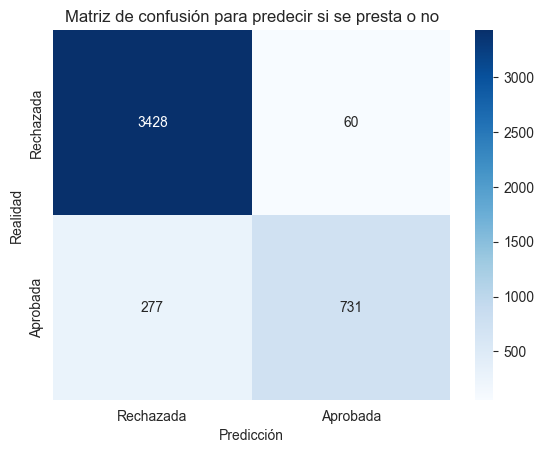

In [45]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Rechazada", "Aprobada"], yticklabels=["Rechazada", "Aprobada"])
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de confusión para predecir si se presta o no")
plt.show()

Vemos un aumento en el número de falsos positivos tras el ajuste de los hiperparámetros, esto puede ser un efecto del sobreajuste (overfitting) o una alteración en el comportamiento del modelo debido a cómo los nuevos parámetros influyen en su capacidad para generalizar.

Durante la optimización de los hiperparámetros, el modelo puede encontrar una configuración que maximiza el rendimiento en el conjunto de validación, pero que no generaliza bien a nuevos datos.
Es posible que ciertos hiperparámetros, como una mayor profundidad (max_depth) o un número de estimadores (n_estimators) elevado, hagan que el modelo sea más complejo y propenso a sobreajustarse.

Hay muchas posibilidades al respecto podríamos considerar la opción de reducir los hiperparámetros a algo más estándar, por ejemplo max_depth a 5. <br><br>

Lo que realizaremos a continuacion es otra funcion personalizada que:
- Tome por parámetro un modelo cualquiera (en nuestro caso el RandomTreeClassifier)
- Prediga sobre los test de la X
- Realice una matriz de confusion sobre la predicción y prueba en y
- Imprima un informe de la clasificacion y los scores
- Realice el mapa de calor en base a la matriz de confusión

In [46]:
def train_validation(model):
    model.fit(X_train,y_train.astype(int))
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_pred, y_test)
    print(classification_report(y_pred, y_test.astype(int)))
    print('score_test = ', model.score(X_test, y_test.astype(int)))
    print('score_train = ', model.score(X_train, y_train.astype(int)))
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Rechazada", "Aprobada"], yticklabels=["Rechazada", "Aprobada"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      3703
           1       0.72      0.92      0.81       793

    accuracy                           0.92      4496
   macro avg       0.85      0.92      0.88      4496
weighted avg       0.94      0.92      0.93      4496

score_test =  0.9241548042704626
score_train =  0.9505338672005339


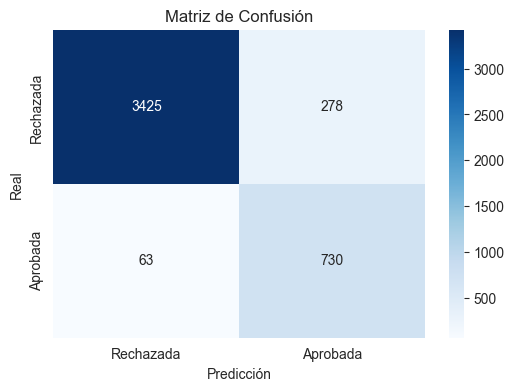

In [47]:
model = RandomForestClassifier(random_state=42, n_estimators=264, max_depth=14, min_samples_split=6)
train_validation(model)

Dada la matriz de confusión se encuentran los siguientes resultados:
- La precisión para la clase 0 es muy alta llegando casi a 1, sin embargo, para la clase 1 la precisión va muy por debajo.
- La sensibilidad (recall), están igual, esto puede interpretarse como un buen rendimiento balanceado entre clases, equilibrio en el manejo de los falsos negativos y en la distribución de datos
- En cuanto al f1-score, vemos para ambas clases positivas y negativas valores respectivamente alto, esto es algo positivo en sí, pues la precisión del modelo y su exhaustividad se podrían considerar correctas

Además de las métricas anteriores, también es importante la <strong>ROC-AUC</strong> (Curva
ROC y área bajo la curva). La AUC mide la capacidad del modelo para separar
correctamente las clases positivas y negativas. Se basa en la curva ROC, que
representa la relación entre la tasa de verdaderos positivos (exhaustividad) y la
tasa de falsos positivos. <br><br>
Interpretación:<br>
• AUC cerca de 1: excelente separación entre clases.<br>
• AUC cerca de 0.5: separación aleatoria (modelo no útil).<br>
• AUC bajo: el modelo clasifica incorrectamente, con resultados peores
que el propio azar.<br><br>

Además, las curvas ROC y las puntuaciones AUC también nos permiten
comparar el rendimiento de diferentes clasificadores para el mismo problema y
así poder elegir el de mayor rendimiento. En el caso que se trata en esta práctica pasaremos directamente a evaluar únicamente el `RandomForestClassifier`



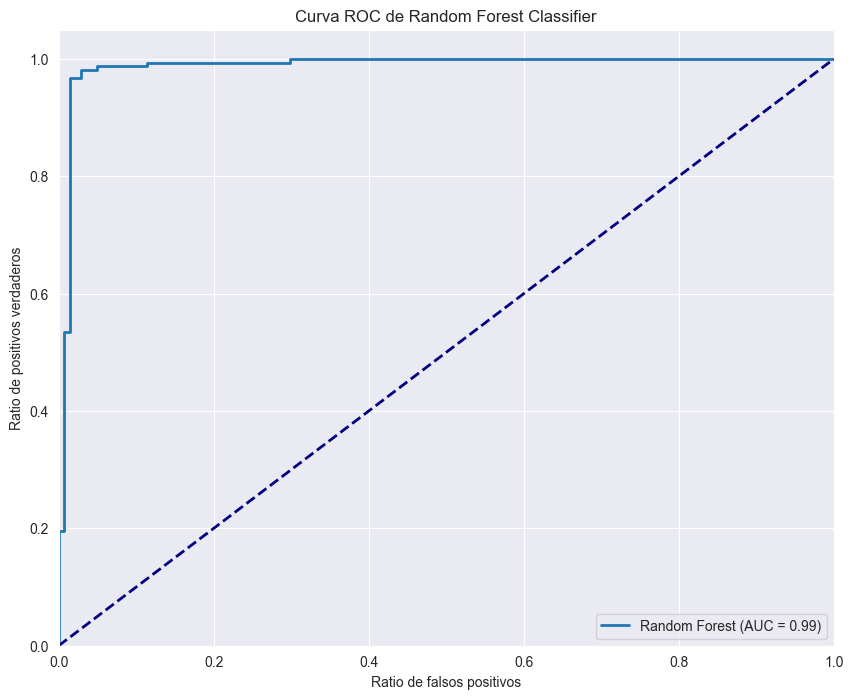

Random Forest: AUC - ROC = 0.99


In [48]:
# Generar clasificacion binaria del dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=0)

# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_probs)

fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=2, label=f'Random Forest (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio de falsos positivos')
plt.ylabel('Ratio de positivos verdaderos')
plt.title('Curva ROC de Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

print(f'Random Forest: AUC - ROC = {roc_auc:.2f}')

AUC-ROC = 0.99 implica que el modelo es capaz de distinguir entre las clases positivas y negativas con un 99% de efectividad. Esto significa que hay muy poca superposición entre las distribuciones de probabilidad predichas para las clases positivas y negativas. En definitiva el modelo sabe diferenciar correctamente cuando dar o no el préstamo

### Conclusión del primer modelo

El objetivo del primer modelo era comprobar si se concede el préstamo o no para posibles nuevos solicitantes, vistos los resultados y las métricas utilizadas podemos concluir que el modelo es apto para realizar las predicciones impertinentes para una entidad bancaria

In [49]:
df.head()

,age,gender,income,yrs_exp,amount,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,...,ownership_MORTGAGE,ownership_OTHER,ownership_OWN,ownership_RENT,purpose_DEBTCONSOLIDATION,purpose_EDUCATION,purpose_HOMEIMPROVEMENT,purpose_MEDICAL,purpose_PERSONAL,purpose_VENTURE
0,22.0,0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,21.0,0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,25.0,0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23.0,0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24.0,1,66135.0,1,35000.0,14.27,0.53,4.0,586,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [50]:
new_client = {
    'age': 30.0,  # Edad en años
    'gender': 1,  # 1 para hombre, 0 para mujer
    'income': 55000.0,  # Ingreso anual en unidades monetarias
    'yrs_exp': 5,  # Años de experiencia laboral
    'amount': 20000.0,  # Cantidad del préstamo solicitado
    'int_rate': 12.5,  # Tasa de interés en porcentaje
    'percent_income': 0.36,  # Monto del préstamo como porcentaje del ingreso
    'cred_hist_length': 7.0,  # Longitud del historial crediticio en años
    'risk_score': 650,  # Puntaje de riesgo crediticio
    'previous_loans': 0,  # 0 indica que no hay préstamos previos predeterminados
    'loan_status': None,  # Este es el objetivo a predecir (1 = aprobado, 0 = rechazado)
    'education_Associate': 0.0,  # Codificación one-hot para el nivel educativo
    'education_Bachelor': 1.0,
    'education_Doctorate': 0.0,
    'education_High School': 0.0,
    'education_Master': 0.0,
    'ownership_MORTGAGE': 1.0,  # Codificación one-hot para el tipo de propiedad
    'ownership_OTHER': 0.0,
    'ownership_OWN': 0.0,
    'ownership_RENT': 0.0,
}
client_df = pd.DataFrame([new_client])


# Realizar predicciones
loan_status = model.predict(client_df)[0]  # Predicción binaria (0 o 1)
loan_prob = model.predict_proba(client_df)[:, 1][0]  # Probabilidad de aprobación

# Mostrar resultados
print(f"Estado del préstamo (loan_status): {'Aprobado' if loan_status == 1 else 'Rechazado'}")
print(f"Probabilidad de aprobación del préstamo: {loan_prob:.2f}")


Estado del préstamo (loan_status): Aprobado
Probabilidad de aprobación del préstamo: 0.80


C:\Users\ESP\Desktop\MachineLearning\saa\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\ESP\Desktop\MachineLearning\saa\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## Segundo modelo: lograr la obtención de la puntuación de riesgo.

Volveremos al [Mapa de calor](#mapa-de-calor) con toda la ingeniería de características realizadas para entrenar y validar el segundo modelo con la variable objetivo `risk_score`


In [51]:
df.head()

,age,gender,income,yrs_exp,amount,int_rate,percent_income,cred_hist_length,risk_score,previous_loans,...,ownership_MORTGAGE,ownership_OTHER,ownership_OWN,ownership_RENT,purpose_DEBTCONSOLIDATION,purpose_EDUCATION,purpose_HOMEIMPROVEMENT,purpose_MEDICAL,purpose_PERSONAL,purpose_VENTURE
0,22.0,0,71948.0,0,35000.0,16.02,0.49,3.0,561,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,21.0,0,12282.0,0,1000.0,11.14,0.08,2.0,504,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,25.0,0,12438.0,3,5500.0,12.87,0.44,3.0,635,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23.0,0,79753.0,0,35000.0,15.23,0.44,2.0,675,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,24.0,1,66135.0,1,35000.0,14.27,0.53,4.0,586,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


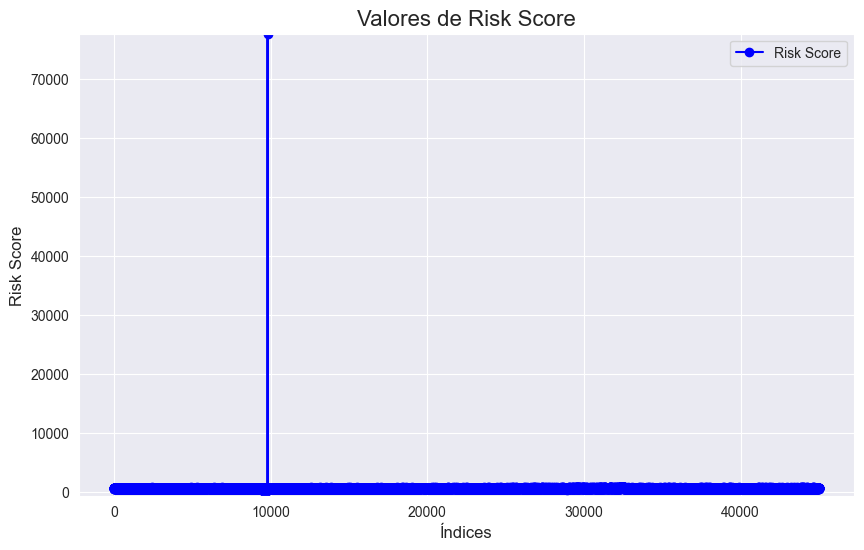

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(df['risk_score'], marker='o', linestyle='-', color='b', label='Risk Score')

# Ajustar los límites del eje y si es necesario
plt.ylim(df['risk_score'].min() - 1, df['risk_score'].max() + 1)

# Etiquetas y título
plt.title('Valores de Risk Score', fontsize=16)
plt.xlabel('Índices', fontsize=12)
plt.ylabel('Risk Score', fontsize=12)

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.show()